# 2-D Daubechies Wavelets

This numerical tour explores 2-D multiresolution analysis 
with Daubchies wavelet transform.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\pa}[1]{\left(#1\right)}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [103]:
from __future__ import division
%pip install scikit-image
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\yacin\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['pylab', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Wavelets Filters

The 2-D wavelet transform of a continuous image $f(x)$ computes the set
of inner products 
$$ d_j^k[n] = \dotp{f}{\psi_{j,n}^k} $$ 
for scales $ j \in \ZZ $, position $ n \in \ZZ^2 $ and orientation $ k \in \{H,V,D\} $.


The wavelet atoms are defined by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:
$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k \left( \frac{x-2^j n}{2^j} \right)  $$
These oriented wavelets are defined by a tensor product of a 1-D wavelet
function $\psi(t)$ and a 1-D scaling function $\phi(t)$
$$ \psi^H(x)=\phi(x_1)\psi(x_2), \quad  \psi^V(x)=\psi(x_1)\phi(x_2)
\qandq \psi^D(x)=\psi(x_1)\psi(x_2).$$


The fast wavelet transform algorithm does not make use of the wavelet and scaling functions,
but of the filters $h$ and $g$ that caracterize their interaction:
$$ g[n] = \frac{1}{\sqrt{2}}\dotp{\psi(t/2)}{\phi(t-n)} 
\qandq h[n] = \frac{1}{\sqrt{2}}\dotp{\phi(t/2)}{\phi(t-n)}. $$


The simplest filters are the Haar filters
$$ h = [1, 1]/\sqrt{2} \qandq g = [-1, 1]/\sqrt{2}. $$


Daubechies wavelets extends the haar wavelets by using longer
filters, that produce smoother scaling functions and wavelets.
Furthermore, the larger the size $p=2k$ of the filter, the higher is the number
$k$ of vanishing moment. 

A high number of vanishing moments allows to better compress regular
parts of the signal. However, increasing the number of vanishing moments
also inceases the size of the support of the wavelets, wich can be
problematic in part where the signal is singular (for instance
discontinuous).

Choosing the _best_ wavelet, and thus choosing $k$, that is adapted to a
given class of signals, thus corresponds to 
a tradeoff between efficiency in regular and singular parts.

- The filter with $k=1$ vanishing moments corresponds to the Haar filter.
- The filter with $k=2$ vanishing moments corresponds to the famous |D4| wavelet, which compresses perfectly linear signals.
- The filter with $k=3$ vanishing moments compresses perfectly quadratic signals.

Select the low pass filter. We start with the Daubechies 4 filter. Note that the filter should have odd 
length, so we zero-padd it.

In [104]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551] 
h = h/norm(h)

Note that the high pass filter $g$ is computed directly from the low pass filter as:
$$ g[n] = (-1)^{1-n}h[1-n]. $$

In [105]:
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))

In [106]:
print(h)
print(g)

[ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
[ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


## Up and Down Filtering

The basic wavelet operation is low/high filtering, followed by down sampling. 

Starting from some 1-D signal $f \in \RR^N$, one thus compute the
low pass signal $a \in \RR^{N/2}$ and the high pass 
signal $d \in \RR^{N/2}$ as
$$ a = (f \star h) \downarrow 2 \qandq 
d = (f \star g) \downarrow 2$$
where the sub-sampling is defined as 
$$ (u \downarrow 2)[k] = u[2k]. $$

Create a random signal $f \in \RR^N$.

In [107]:
N = 256
f = rand(N,1)

Low/High pass filtering followed by sub-sampling.

In [108]:
a = subsampling( cconv(f,h,1),1 )
d = subsampling( cconv(f,g,1),1 )

For orthogonal filters, the reverse of this process is its dual
(aka its transpose), which is upsampling followed by low/high pass
filtering with the reversed filters and summing:
$$ (a \uparrow h) \star \tilde h + (d \uparrow g) \star \tilde g = f $$
where $\tilde h[n]=h[-n]$ (computed modulo $N$) and 
$ (u \uparrow 2)[2n]=u[n] $ and  $ (u \uparrow 2)[2n+1]=0 $.

Perform the up-sampling followed by filtering.

In [109]:
f1 =  cconv(upsampling(a,1),reverse(h),1) + cconv(upsampling(d,1),reverse(g),1)

Check that we really recover the same signal.

In [110]:
print( C)

NameError: name 'C' is not defined

## Forward 2-D Wavelet transform

The set of wavelet coefficients are computed with a fast algorithm that
exploits the embedding of the approximation spaces $V_j$ spanned by the 
scaling function $ \{ \phi_{j,n} \}_n $ defined as
$$ \phi_{j,n}(x) = \frac{1}{2^j}\phi^0\pa{\frac{x-2^j n}{2^j}} 
\qwhereq \phi^0(x)=\phi(x_1)\phi(x_2). $$

The wavelet transform of $f$ is computed by using intermediate discretized low
resolution images obtained by projection on the spaces $V_j$:
$$ a_j[n] = \dotp{f}{\phi_{j,n}}. $$

Load a gray-scale image $f$ of $n \times n$ pixels. 

In [ ]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)

Display the image $f$.

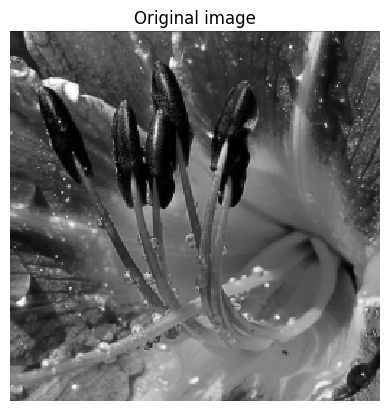

In [ ]:
imageplot(f, 'Original image')

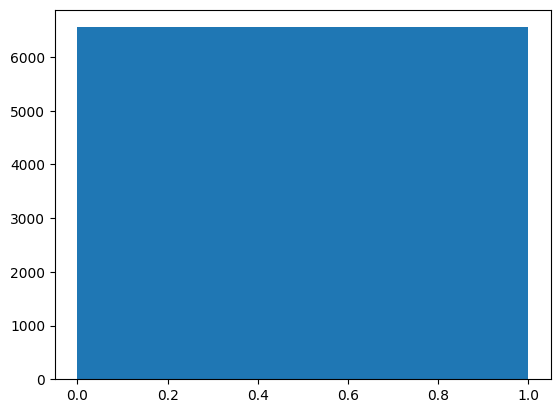

In [ ]:
f0 = f
f1 = f.flatten()
f1[ argsort(f0.flatten()) ] = np.linspace(0,1,n*n)
hist(f1.flatten())
I = argsort(f0.flatten())

The algorithm starts at the coarsest scale $ j=\log_2(n)-1 $

In [ ]:
j = int(log2(n)-1)


The first step of the algorithm perform filtering/downsampling in the
horizontal direction.

$$ \tilde a_{j-1} = (a_j \star^H h) \downarrow^{2,H}  \qandq 
   \tilde d_{j-1} = (a_j \star^H g) \downarrow^{2,H}$$

Here, the operator $\star^H$ and $\downarrow^{2,H}$
are defined by applying $\star$ and $\downarrow^2$
to each column of the matrix.

The second step computes the filtering/downsampling in the vertical
direction.

$$ a_{j-1}   = (\tilde a_j \star^V h) \downarrow^{2,V}  \qandq 
   d_{j-1}^V = (\tilde a_j \star^V g) \downarrow^{2,V},$$
$$ d_{j-1}^H = (\tilde d_j \star^V h) \downarrow^{2,V}  \qandq 
   d_{j-1}^D = (\tilde d_j \star^V g) \downarrow^{2,V}.$$
    
A wavelet transform is
computed by iterating high pass and loss pass filterings with |h| and |g|, followed by sub-samplings.
Since we are in 2-D, we need to compute these filterings+subsamplings
in the horizontal and then in the vertical direction (or
in the reverse order, it does not mind).

Initialize the transformed coefficients as the image itself and set the
initial scale as the maximum one.
fW will be iteratively transformated and will contains the
coefficients.

In [ ]:
fW = f.copy()

Select the sub-part of the image to transform.

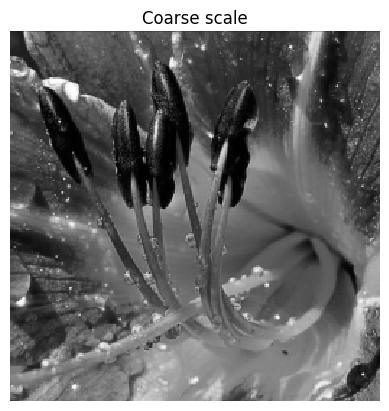

In [ ]:
A = fW[:2**(j+1):,:2**(j+1):]
imageplot(A, 'Coarse scale')

Apply high and low filtering+subsampling in the vertical direction (1st ooordinate),
to get coarse and details.

In [ ]:
Coarse = subsampling(cconv(A,h,1),1)
Detail = subsampling(cconv(A,g,1),1)

Concatenate them in the vertical direction to get the result.

In [ ]:
A = concatenate( (Coarse, Detail), axis=0 )

Display the result of the vertical transform.

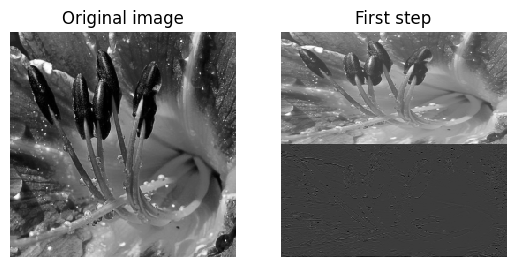

In [ ]:
imageplot(f, 'Original image', [1,2,1])
imageplot(A, 'First step', [1,2,2])

Apply high and low filtering+subsampling in the horizontal direction (2nd ooordinate),
to get coarse and details.

In [ ]:
Coarse = subsampling(cconv(A,h,2),2)
Detail = subsampling(cconv(A,g,2),2)

Concatenate them in the horizontal direction to get the result.

In [ ]:
A = concatenate( (Coarse, Detail), axis=1 )

Assign the transformed data.

In [ ]:
fW[:2**(j+1):,:2**(j+1):] = A

Display the result of the horizontal transform.

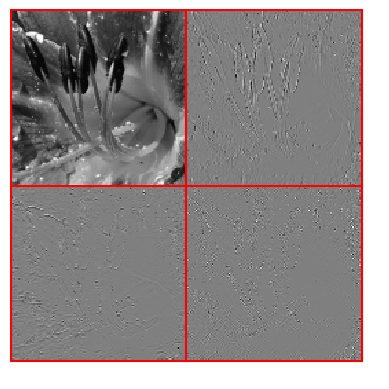

In [ ]:
plot_wavelet(fW,j);

Implement a full wavelet transform that extract iteratively wavelet
coefficients, by repeating these steps. Take care of choosing the
correct number of steps.

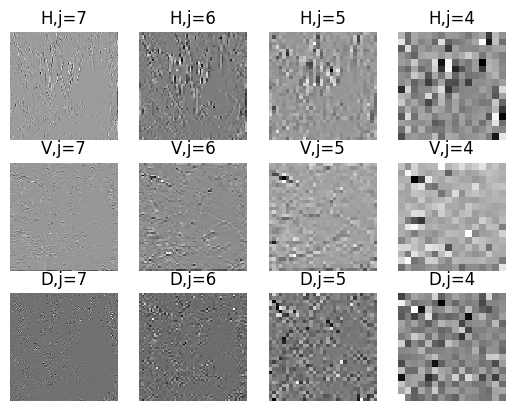

In [ ]:
Jmin = 0
Jmax = int(log2(n)-1)
fW = f.copy()
for j in arange(Jmax, Jmin - 1, -1):
# Convertir j en entier
    A = fW[:2**(j+1):,:2**(j+1):]
    for d in arange(1,3):
        Coarse = subsampling(cconv(A,h,d),d)
        Detail = subsampling(cconv(A,g,d),d)
        A = concatenate( (Coarse, Detail), axis=d-1 )
    fW[:2**(j+1):,:2**(j+1):] = A
    j1 = Jmax-j
    j1 = int(j1)
    if j1<4:
        subplot(3,4, j1 + 1)
        imageplot(A[:2**j:,2**j:2**(j+1):], 'H,j=' + str(int(j)) )
        subplot(3,4, j1 + 5)
        imageplot(A[2**j:2**(j+1):,:2**j:], 'V,j=' + str(int(j)) )
        subplot(3,4, j1 + 9)
        imageplot(A[2**j:2**(j+1):,2**j:2**(j+1):], 'D,j=' + str(int(j)))

Check for orthogonality of the transform (conservation of energy).

In [ ]:
print( 'Energy of the signal/coefficients = ' + str(norm(f)/norm(fW)) )

Energy of the signal/coefficients = 1.0000049


Display the wavelet coefficients.

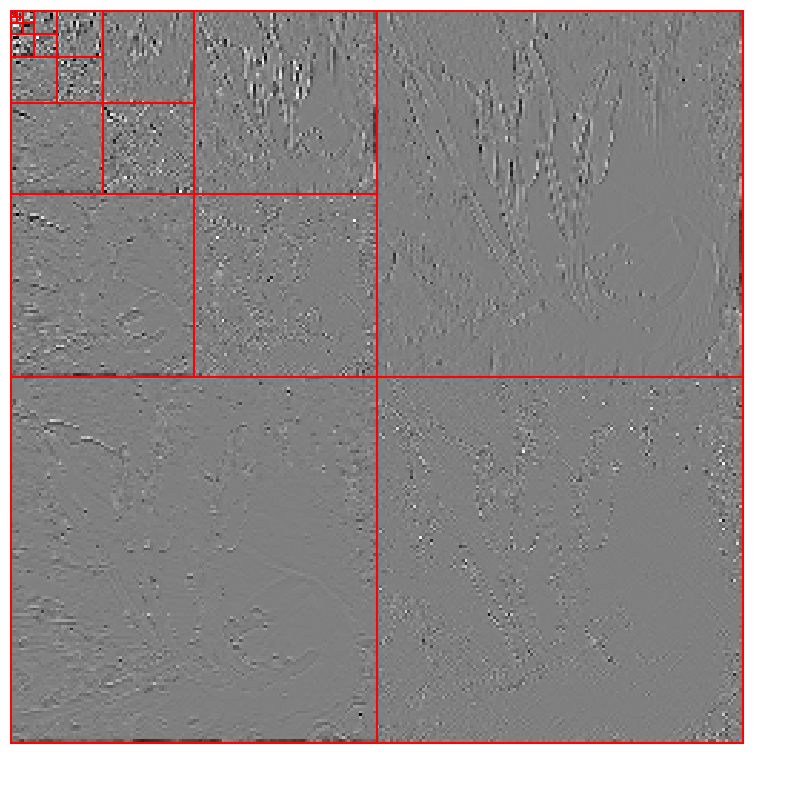

In [ ]:
plt.figure(figsize=(10,10))
plot_wavelet(fW,Jmin);




## Inverse 2-D Wavelet transform

Inversing the wavelet transform means retrieving a signal `f1` from the
coefficients `fW`. If `fW` are exactely the coefficients of `f`, then
`f=f1` up to machine precision. 

Initialize the image to recover `f1` as the transformed coefficient, and
select the smallest possible scale.

In [ ]:
f1 = fW
j = 0

Select the sub-coefficient to transform.

In [ ]:
A = f1[:2**(j+1):,:2**(j+1):]

Retrieve coarse and detail coefficients in the vertical direction (you
can begin by the other direction, this has no importance).

In [ ]:
Coarse = A[:2**j:,:]
Detail = A[2**j:2**(j+1):,:]

Undo the transform by up-sampling and then dual filtering.

In [ ]:
Coarse = cconv(upsampling(Coarse,1),reverse(h),1)
Detail = cconv(upsampling(Detail,1),reverse(g),1)

Recover the coefficient by summing.

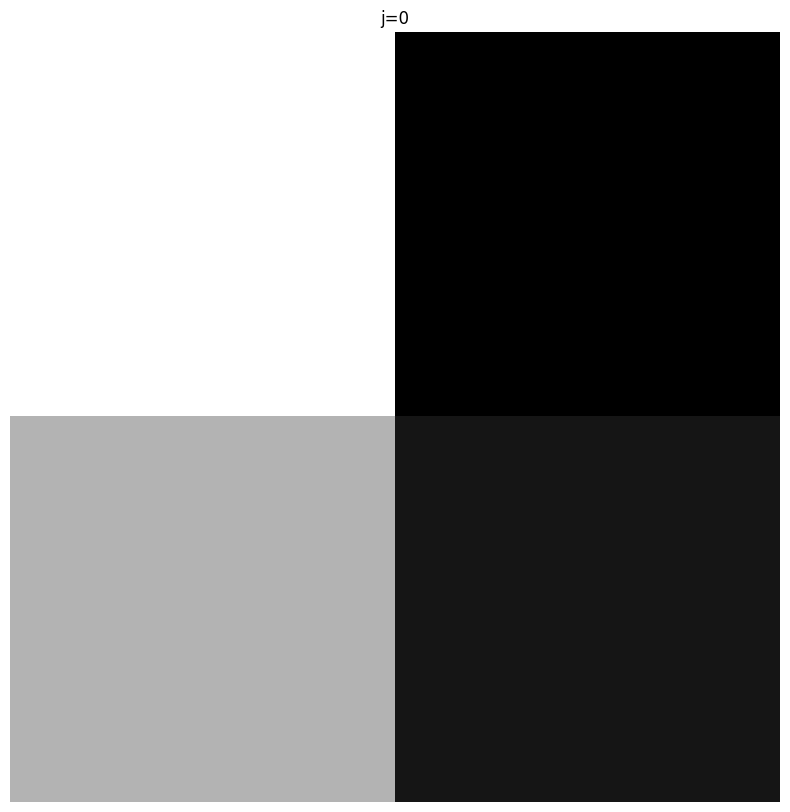

In [ ]:
A = Coarse + Detail
plt.figure(figsize=(10,10))
imageplot(A, 'j=' + str(j))

Retrieve coarse and detail coefficients in the vertical direction (you
can begin by the other direction, this has no importance).

In [ ]:
Coarse = A[:,:2**j:]
Detail = A[:,2**j:2**(j+1):]

Undo the transform by up-sampling and then dual filtering.

In [ ]:
Coarse = cconv(upsampling(Coarse,2),reverse(h),2)
Detail = cconv(upsampling(Detail,2),reverse(g),2)

Recover the coefficient by summing.

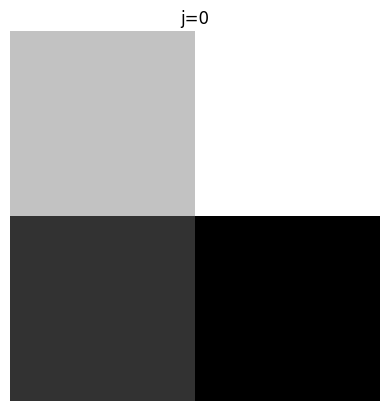

In [ ]:
A = Coarse + Detail
plt.Figure(figsize=(10,10))
imageplot(A, 'j=' + str(j))

Assign the result.

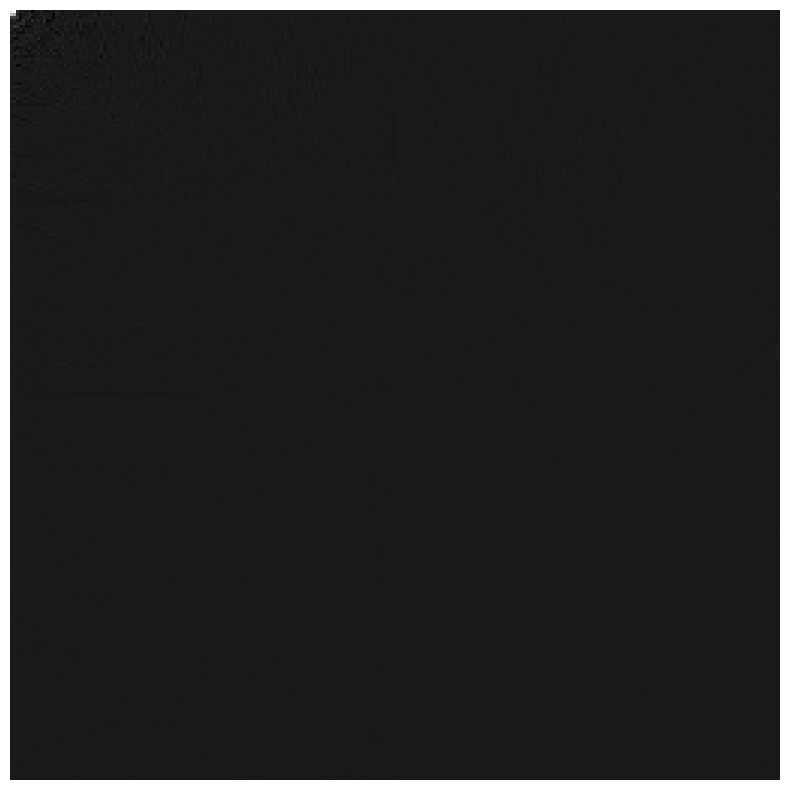

In [ ]:
f1[:2**(j+1), :2**(j+1)] = A
plt.figure(figsize=(10,10))
imageplot(f1)

Write the inverse wavelet transform that computes `f1` from the
coefficients `fW`. Compare `f1` with `f`.

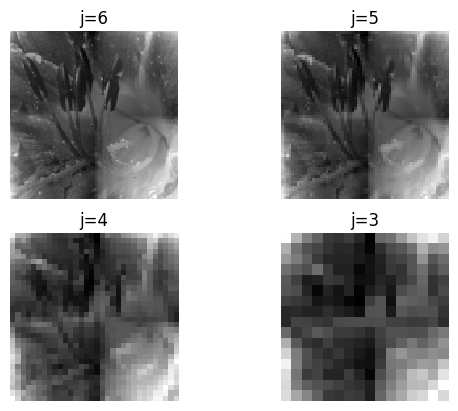

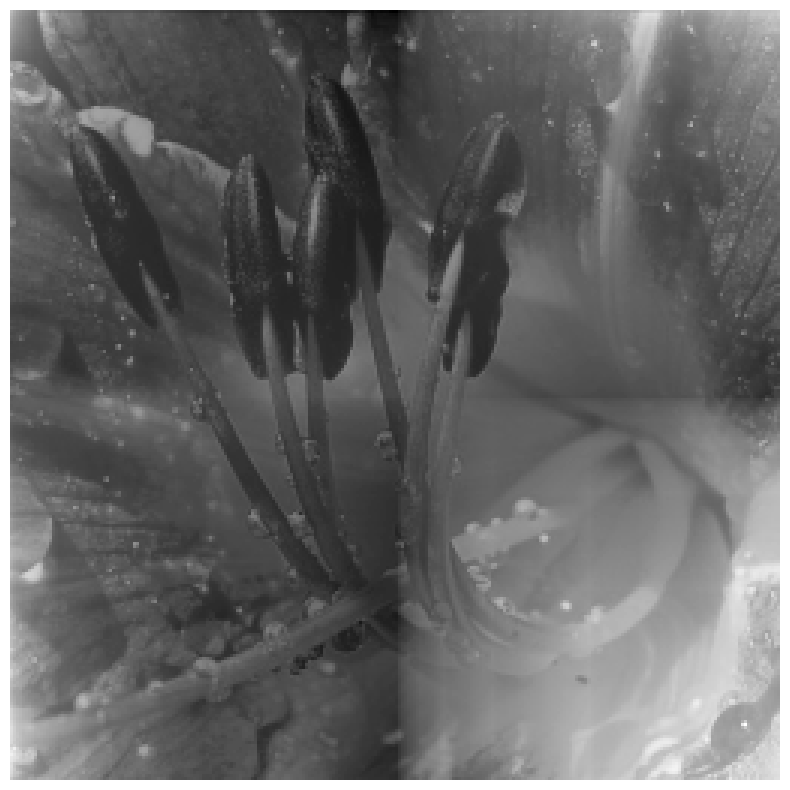

In [ ]:
f1 = fW.copy()
for j in arange(Jmin,Jmax+1): 
    A = f1[:2**(j+1):,:2**(j+1):]
    for d in arange(1,3):
        if d==1:
            Coarse = A[:2**j:,:]
            Detail = A[2**j:2**(j+1):,:]
        else:
            Coarse = A[:,:2**j:]
            Detail = A[:,2**j:2**(j+1):]
        Coarse = cconv(upsampling(Coarse,d),reverse(h),d)
        Detail = cconv(upsampling(Detail,d),reverse(g),d)
        A = Coarse + Detail
        j1 = Jmax-j
        if j1>0 and j1<5:
            imageplot(A, 'j=' + str(int(j)), [2,2,j1])
    f1[:2**(j+1):,:2**(j+1):] = A

plt.figure(figsize=(10,10))
imageplot(f1)

Check that we recover exactly the original image.

In [ ]:
print( 'Error |f-f1|/|f| = ' + str(norm(f-f1)/norm(f)) )

Error |f-f1|/|f| = 0.81805253


## Linear 2-D Wavelet Approximation

Linear approximation is performed by setting to zero the fine scale wawelets coefficients
and then performing the inverse wavelet transform.

Here we keep only 1/16 of the wavelet coefficient, thus calculating an $m$
term approximation with $m=n^2/16$.

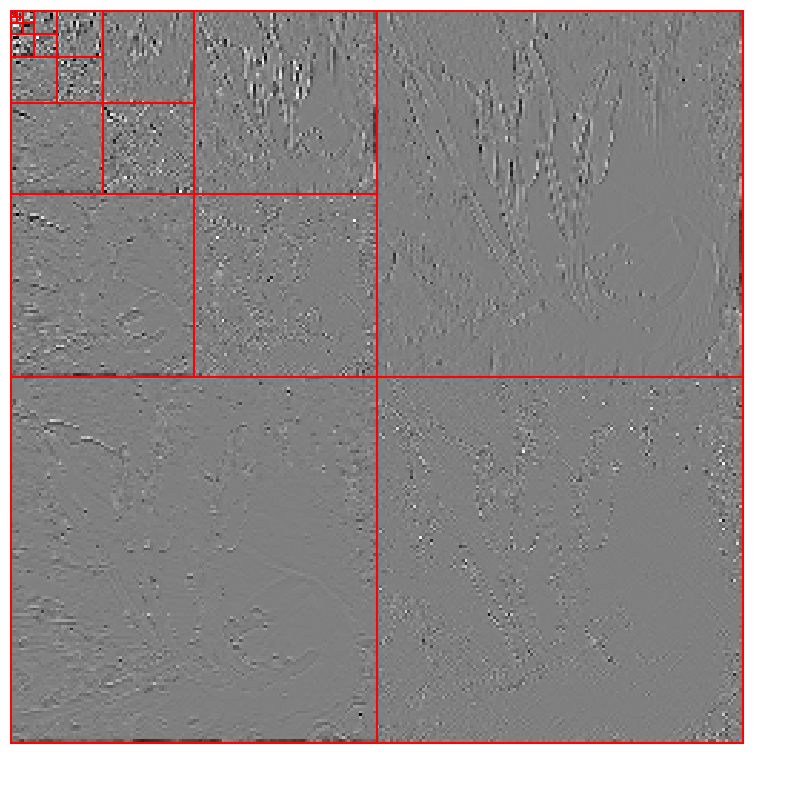

In [ ]:
fW = perform_wavortho_transf(f,Jmin,+1,h)
plt.figure(figsize=(10,10))
plot_wavelet(fW,Jmin)
eta = 4
fWLin = zeros((n,n))
fWLin[:int(n/eta):,:int(n/eta):] = fW[:int(n/eta):,:int(n/eta):]
fLin = perform_wavortho_transf(fWLin,Jmin,-1,h)

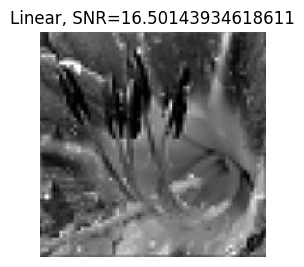

In [ ]:
elin = snr(f,fLin)
imageplot(clamp(fLin), 'Linear, SNR=' + str(elin), [1,2,2] )

## Non-Linear 2-D Wavelet Approximation

A non-linear $m$-term approximation is obtained by keeping only the $m$
largest coefficients, which creates the smallest possible error.


Removing the smallest coefficient, to keep the $m$-largest, is
equivalently obtainedby thresholding the coefficients to
set to 0 the smallest coefficients. 


First select a threshold value (the largest the threshold, the more
agressive the approximation).

In [ ]:
T = .2

Then set to 0 coefficients with magnitude below the threshold.

In [ ]:
fWT = fW * (abs(fW)>T)

Display thresholded coefficients.

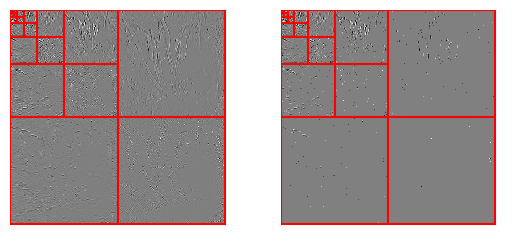

In [ ]:
subplot(1,2,1)
plot_wavelet(fW,Jmin);
subplot(1,2,2)
plot_wavelet(fWT,Jmin);

Plot the (log of) the coefficient in decaying order.

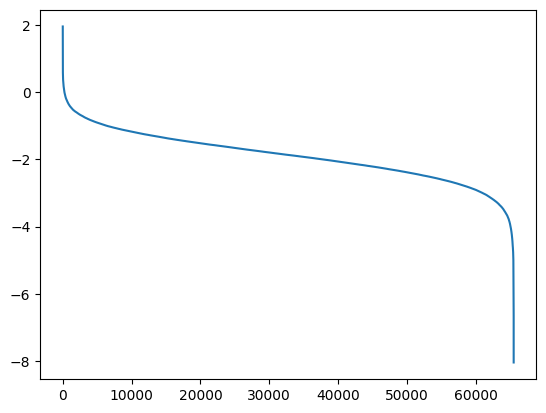

In [ ]:
m = round((n**2)/(eta**2))
v = reverse( np.sort(abs(fW).ravel()) )
plot(log10(v))
axis('tight');

Find the thresholds $T$ so that the number $m$ of remaining coefficients in the threshold coefficients
are $m=n^2/16$. 

In [ ]:
T = v[m]

Display the corresponding non-linear approximation.

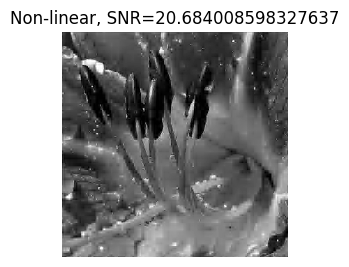

In [ ]:
fWT = fW * (abs(fW)>=T)
fnl = perform_wavortho_transf(fWT,Jmin,-1,h)
enl = snr(f,fnl)
imageplot(clamp(fnl), 'Non-linear, SNR=' + str(enl), [1,2,2] )

# Exercise

#### Exercise 1: Compare the approximation obtained using wavelet with different number of vanishing moments.

Creation of the daubechies  low pass filters


In [ ]:
hdb4=[0,0.48296, 0.83651, 0.22414, -0.12941]
hdb4=hdb4/norm(hdb4)
hdb6=[0,0.33267, 0.80689, 0.45988, -0.13501, -0.085441, 0.035226]
hdb6=hdb6/norm(hdb6)
hdb8=[0,0.23038, 0.71485, 0.63088, -0.027983, -0.18703, 0.030841, 0.032883, -0.010597]
hdb8=hdb8/norm(hdb8)
hdb10=[0,0.1601, 0.60383, 0.72431, 0.138428, -0.242294, -0.032244, 0.077571, -0.0062415, -0.01258075, 0.003335725]
hdb10=hdb10/norm(hdb10)
HDB=[hdb4,hdb6,hdb8,hdb10]

Compute the high pass from low pass


In [ ]:
GDB=[]
for i in range(len(HDB)):
    h = HDB[i]
    u = power(-ones(len(h)-1), range(1, len(h)))  # alternate +1/-1
    g = concatenate(([0], h[-1:0:-1] * u))
    globals()[f'gdb{i*2+4}'] = g
    GDB.append(g)
print( GDB)



[array([ 0.        ,  0.12941097,  0.22414168, -0.83651626,  0.48296362]), array([ 0.        , -0.03522601, -0.08544104,  0.13501006,  0.4598802 ,
       -0.80689034,  0.33267014]), array([ 0.        ,  0.01059698,  0.03288295, -0.03084095, -0.18702971,
        0.02798296,  0.63087903, -0.7148489 ,  0.23037965]), array([ 0.        , -0.00333572, -0.01258074,  0.00624149,  0.07757094,
        0.03224397, -0.2422938 , -0.13842789,  0.72430941, -0.6038295 ,
        0.16009987])]


Import the image 


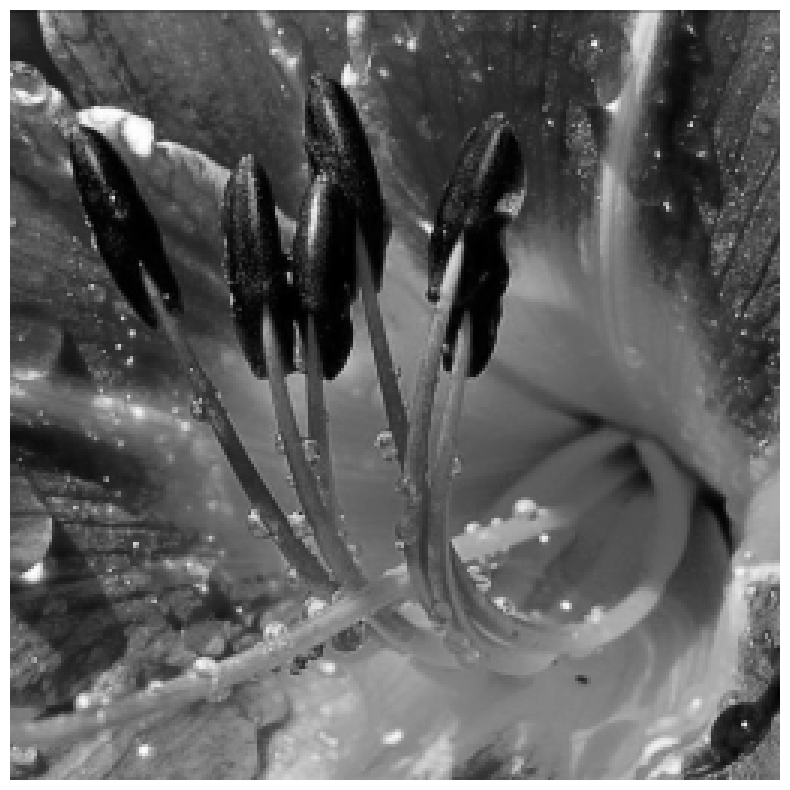

In [ ]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)
plt.figure(figsize=(10,10))
imageplot(f)


Apply the wavelet transformation for each daubechies filter


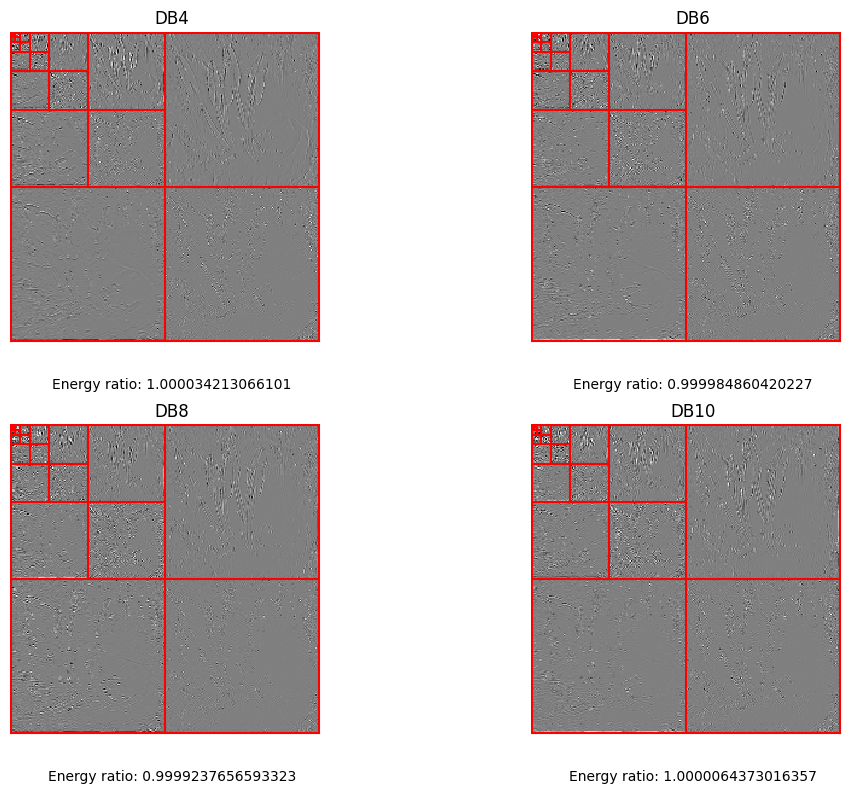

In [ ]:
FWS=[]

for i in range(len(HDB)):
    h = HDB[i]
    g = GDB[i]
    Jmax = int(log2(n)-1)
    Jmin = 0
    fW = f.copy()
    for j in arange(Jmax, Jmin - 1, -1):
    # Convertir j en entier
        A = fW[:2**(j+1):,:2**(j+1):]
        for d in arange(1,3):
            Coarse = subsampling(cconv(A,h,d),d)
            Detail = subsampling(cconv(A,g,d),d)
            A = concatenate( (Coarse, Detail), axis=d-1 )
        fW[:2**(j+1):,:2**(j+1):] = A
    FWS.append(fW)

# Plot the wavelet transforms
plt.figure(figsize=(12, 8))
names = ['DB4', 'DB6', 'DB8', 'DB10']
for i in range(len(HDB)):
    fW = FWS[i]
    plt.subplot(2, 2, i + 1)
    plot_wavelet(fW, Jmin)
    plt.title(names[i])
    plt.text(0.5, -0.1, f'Energy ratio: {norm(f)/norm(fW)}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()



Inverse transformation for each daubechies wavelet


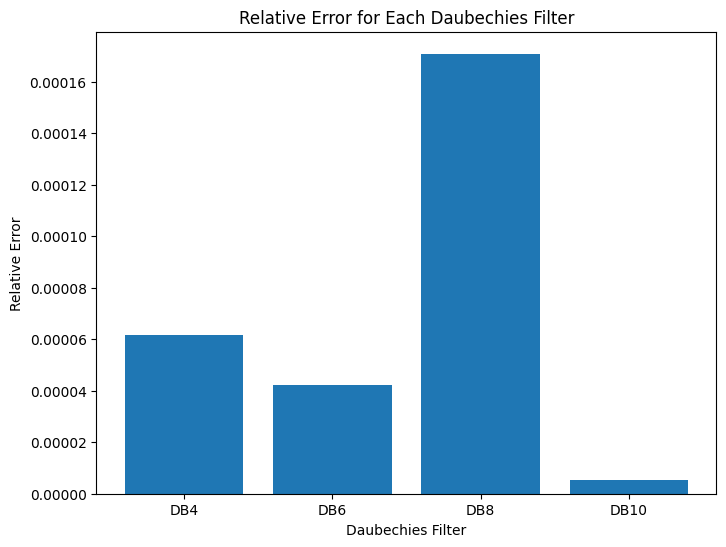

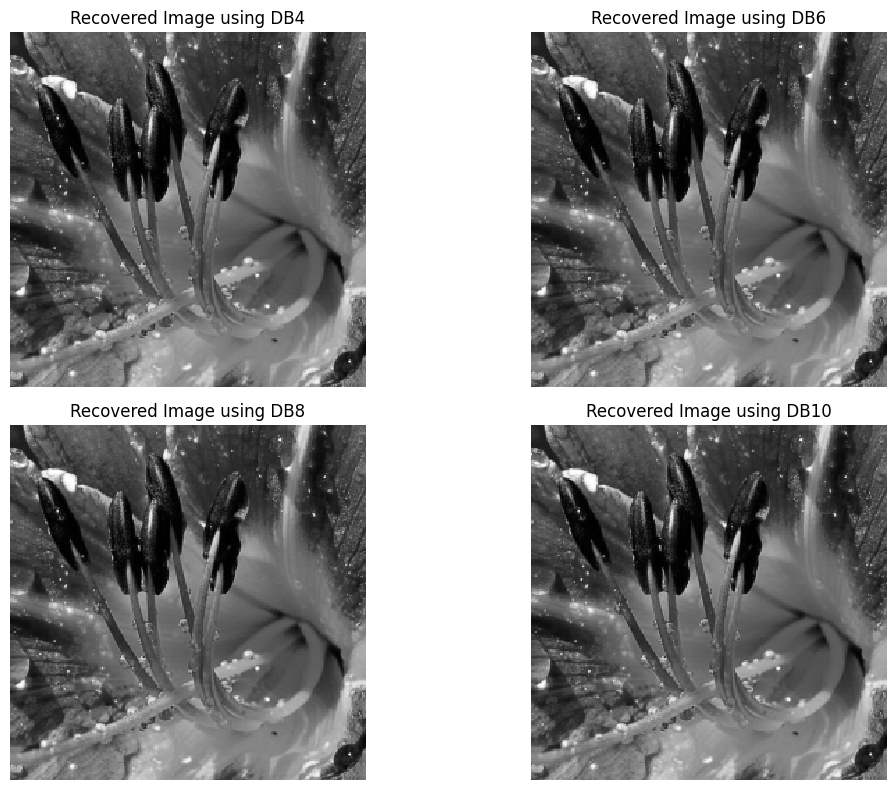

In [ ]:

recovered_images = []

for i in range(len(FWS)):
    fW = FWS[i]
    h = HDB[i]
    g = GDB[i]
    f1 = fW.copy()
    for j in arange(Jmin,Jmax+1): 
        A = f1[:2**(j+1):,:2**(j+1):]
        for d in arange(1,3):
            if d==1:
                Coarse = A[:2**j:,:]
                Detail = A[2**j:2**(j+1):,:]
            else:
                Coarse = A[:,:2**j:]
                Detail = A[:,2**j:2**(j+1):]
            Coarse = cconv(upsampling(Coarse,d),reverse(h),d)
            Detail = cconv(upsampling(Detail,d),reverse(g),d)
            A = Coarse + Detail
        f1[:2**(j+1):,:2**(j+1):] = A
        

    recovered_images.append(f1)
errors = [norm(f - recovered_images[i]) / norm(f) for i in range(len(recovered_images))]

# Plot the errors
plt.figure(figsize=(8, 6))
plt.bar(names, errors)
plt.xlabel('Daubechies Filter')
plt.ylabel('Relative Error')
plt.title('Relative Error for Each Daubechies Filter')
plt.show()
# Display the recovered images
plt.figure(figsize=(12, 8))
for i in range(len(recovered_images)):
    plt.subplot(2, 2, i + 1)
    imageplot(recovered_images[i], f'Recovered Image using {names[i]}')
plt.tight_layout()
plt.show()

## Let's try to see the effect of other wavelets (Haar, Coifman,Battle-Lemarié,meyer)


Define the filters

In [ ]:
import pywt

# Haar wavelet filter
haar_wavelet = pywt.Wavelet('haar')
haar_low_pass = haar_wavelet.dec_lo
haar_high_pass = haar_wavelet.dec_hi

# Coifman wavelet filter (Coif1)
coif1_wavelet = pywt.Wavelet('coif6')
coif1_low_pass = coif1_wavelet.dec_lo
coif1_high_pass = coif1_wavelet.dec_hi

battle_lemarie_low_pass = [0.0352262918821, -0.0854412738820, -0.1350110200103, 0.4598775021185, 
                           0.8068915093133, 0.3326705529500]
battle_lemarie_high_pass = [-0.3326705529500, 0.8068915093133, -0.4598775021185, -0.1350110200103, 
                            0.0854412738820, 0.0352262918821]

meyer_wavelet = pywt.Wavelet('dmey')
meyer_low_pass = meyer_wavelet.dec_lo
meyer_high_pass = meyer_wavelet.dec_hi


debauchies_low_pass = HDB[-1]
debauchies_high_pass = GDB[-1]

H=[haar_low_pass, coif1_low_pass, battle_lemarie_low_pass, meyer_low_pass, debauchies_low_pass]
G=[haar_high_pass, coif1_high_pass, battle_lemarie_high_pass, meyer_high_pass, debauchies_high_pass]
print(H)
print(G)


[[0.7071067811865476, 0.7071067811865476], [-5.309088417196894e-09, -8.487143396262437e-09, 1.3503244993561446e-07, 2.255997852816182e-07, -1.6596192951024209e-06, -2.924385559757523e-06, 1.3139851354021442e-05, 2.473655932872323e-05, -7.528004306935965e-05, -0.0001545771992797995, 0.0003252223590102408, 0.0007698547307507267, -0.0011574350134273348, -0.0030739395072085594, 0.0038576582705936867, 0.009591090175904054, -0.012650067908732352, -0.022950153279849065, 0.03888132625151076, 0.04185249067613627, -0.11226080796481724, -0.0581089179726148, 0.4404011911268528, 0.7684032575798925, 0.42581954501283853, -0.04876407217567388, -0.09967300204601176, 0.02878611434666557, 0.029645772891323842, -0.012231577790037914, -0.007029406391002729, 0.0035390198715409982, 0.0010916247123259031, -0.0006246130439256836, -8.117002626784841e-05, 5.0775487836340565e-05], [0.0352262918821, -0.085441273882, -0.1350110200103, 0.4598775021185, 0.8068915093133, 0.33267055295], [0.0, -1.009999956941423e-12, 8

In [ ]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)



Apply the wavelet transform

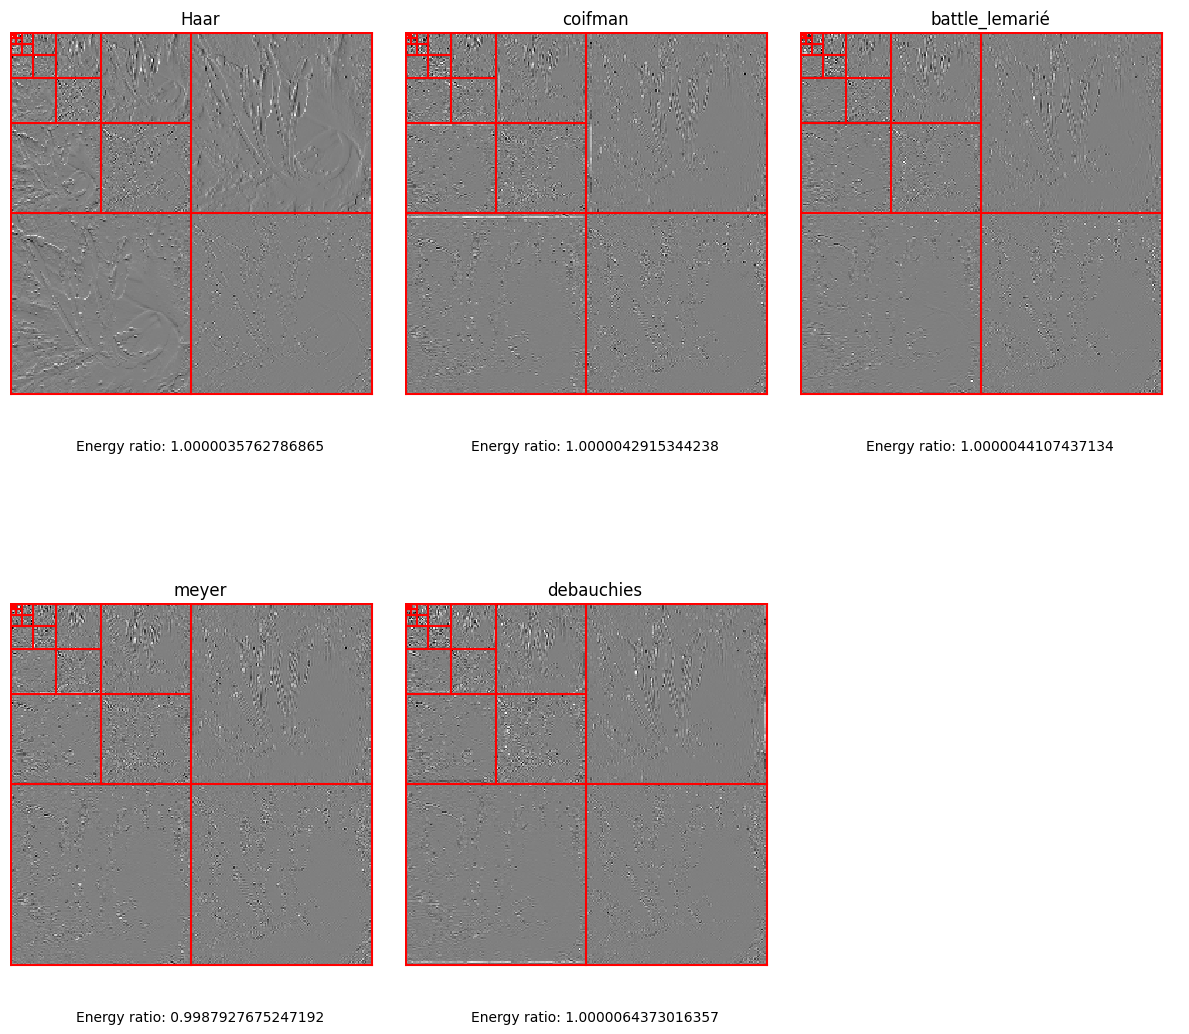

In [ ]:
FWS=[]

for i in range(len(H)):
    h = H[i]
    g = G[i]
    Jmax = int(log2(n)-1)
    Jmin = 0
    fW = f.copy()
    for j in arange(Jmax, Jmin - 1, -1):
    # Convertir j en entier
        A = fW[:2**(j+1):,:2**(j+1):]
        for d in arange(1,3):
            Coarse = subsampling(cconv(A,h,d),d)
            Detail = subsampling(cconv(A,g,d),d)
            A = concatenate( (Coarse, Detail), axis=d-1 )
        fW[:2**(j+1):,:2**(j+1):] = A
    FWS.append(fW)

# Plot the wavelet transforms
plt.figure(figsize=(12, 12))
names = ['Haar', 'coifman', 'battle_lemarié', 'meyer', 'debauchies']    
for i in range(len(H)):
    fW = FWS[i]
    plt.subplot(2, 3, i + 1)
    plot_wavelet(fW, Jmin)
    plt.title(names[i])
    plt.text(0.5, -0.1, f'Energy ratio: {norm(f)/norm(fW)}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

Apply the inverse tranform and compute the reconstruction error


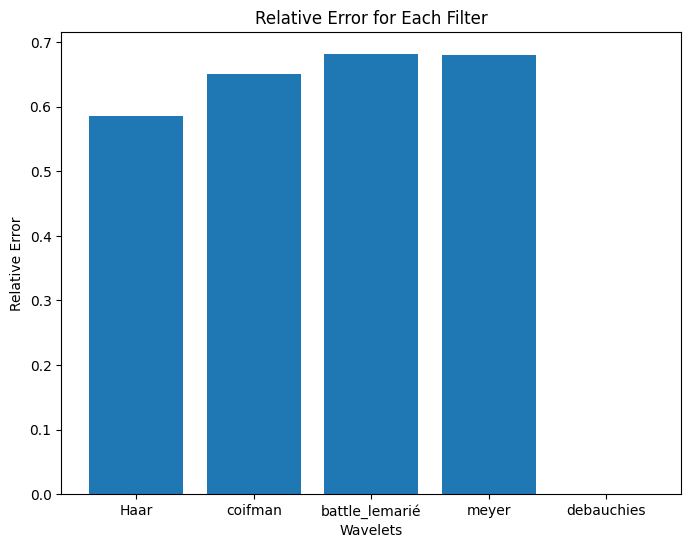

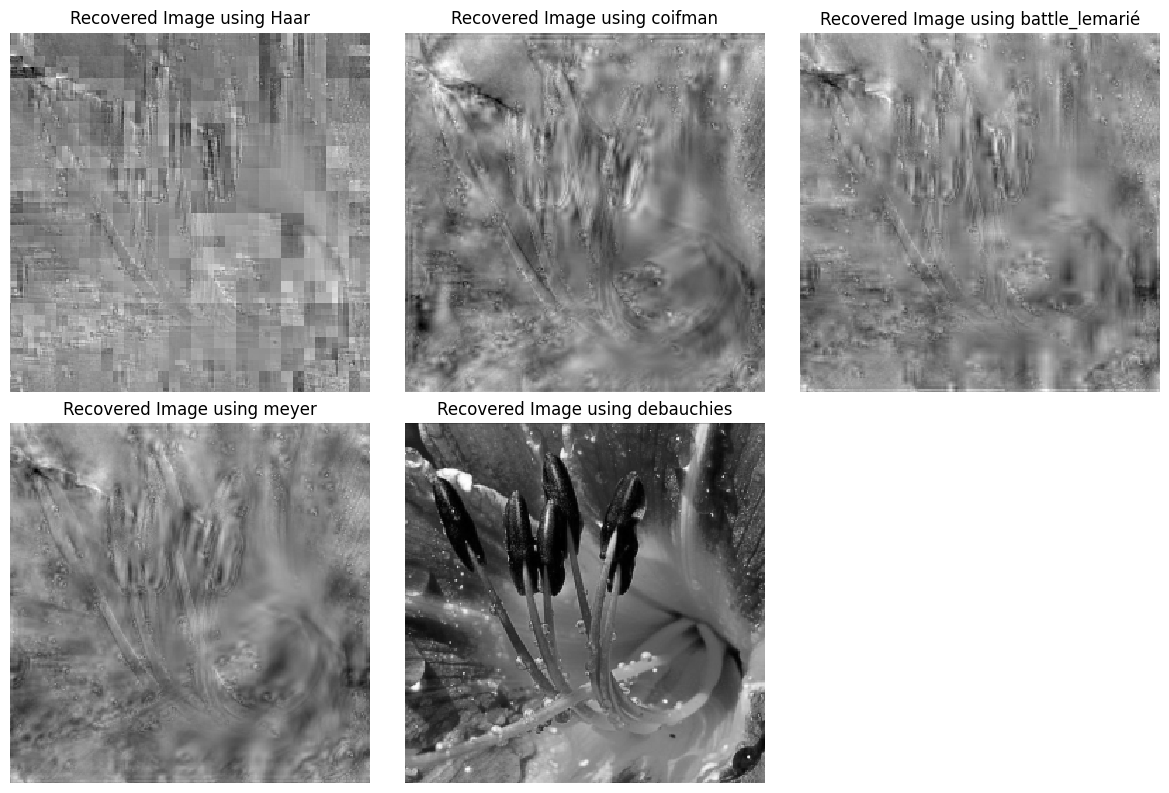

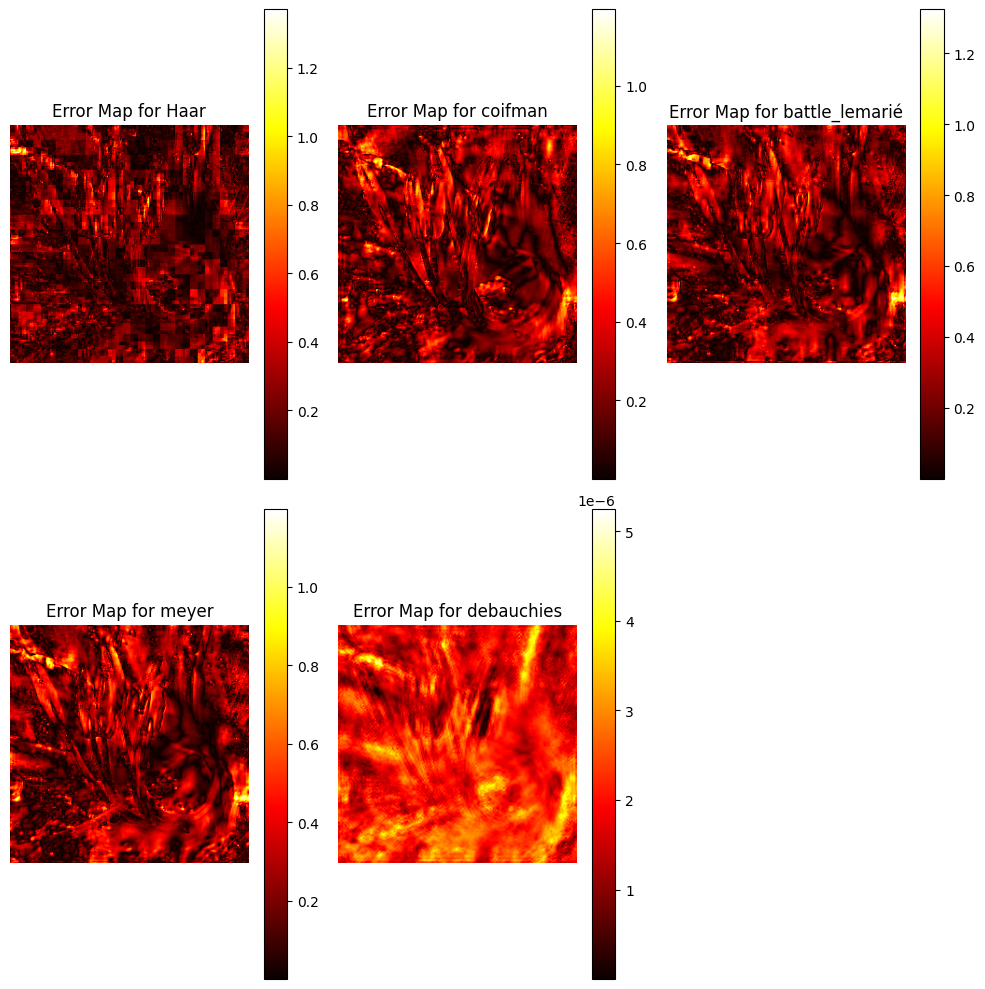

In [116]:
recovered_images = []

for i in range(len(FWS)):
    fW = FWS[i]
    h = H[i]
    g = G[i]
    f1 = fW.copy()
    for j in arange(Jmin,Jmax+1): 
        A = f1[:2**(j+1):,:2**(j+1):]
        for d in arange(1,3):
            if d==1:
                Coarse = A[:2**j:,:]
                Detail = A[2**j:2**(j+1):,:]
            else:
                Coarse = A[:,:2**j:]
                Detail = A[:,2**j:2**(j+1):]
            Coarse = cconv(upsampling(Coarse,d),reverse(h),d)
            Detail = cconv(upsampling(Detail,d),reverse(g),d)
            A = Coarse + Detail
        f1[:2**(j+1):,:2**(j+1):] = A
        

    recovered_images.append(f1)
rel_errors = [norm(f - recovered_images[i]) / norm(f) for i in range(len(recovered_images))]
errors = [np.abs(f - recovered_images[i]) for i in range(len(recovered_images))]
# Plot the errors
plt.figure(figsize=(8, 6))
plt.bar(names, rel_errors)
plt.xlabel('Wavelets')
plt.ylabel('Relative Error')
plt.title('Relative Error for Each Filter')
plt.show()
# Display the recovered images
plt.figure(figsize=(12, 8))
for i in range(len(recovered_images)):
    plt.subplot(2, 3, i + 1)
    imageplot(recovered_images[i], f'Recovered Image using {names[i]}')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,10))
for i in range(len(errors)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(errors[i], cmap='hot')
    plt.title('Error Map for ' + names[i])
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show()

### Analysis of Wavelet-Based Reconstructions

##### Haar:  
The reconstruction shows significant pixelation due to the discontinuity and simplicity of the Haar basis. This wavelet fails to effectively capture fine details and smooth transitions, resulting in a rudimentary image.

##### Coifman:  
The reconstruction exhibits artifacts and a loss of clarity, though the main structures remain discernible. These limitations arise from insufficient frequency resolution and partial smoothing of details.

##### Battle-Lemarié:  
Similar to Coifman, this reconstruction suffers from artifacts and poor preservation of details. The Battle-Lemarié wavelet lacks precision in representing complex details.

##### Meyer:  
This reconstruction better preserves global structures and smooth transitions. However, some blurring artifacts persist, likely due to the complexity of Meyer filters in the temporal domain.

##### Daubechies:  
The reconstruction is the most faithful to the original image. Thanks to its orthogonality properties and ability to capture both local details and global structures, the Daubechies wavelet produces a precise and well-balanced result.

*Exercise 3:* Display a 2-D wavelet by applying the backward transform to a Dirac (i.e. all zeros excepted a single 1 at a well-chosen position).

Apply the inverse transformation

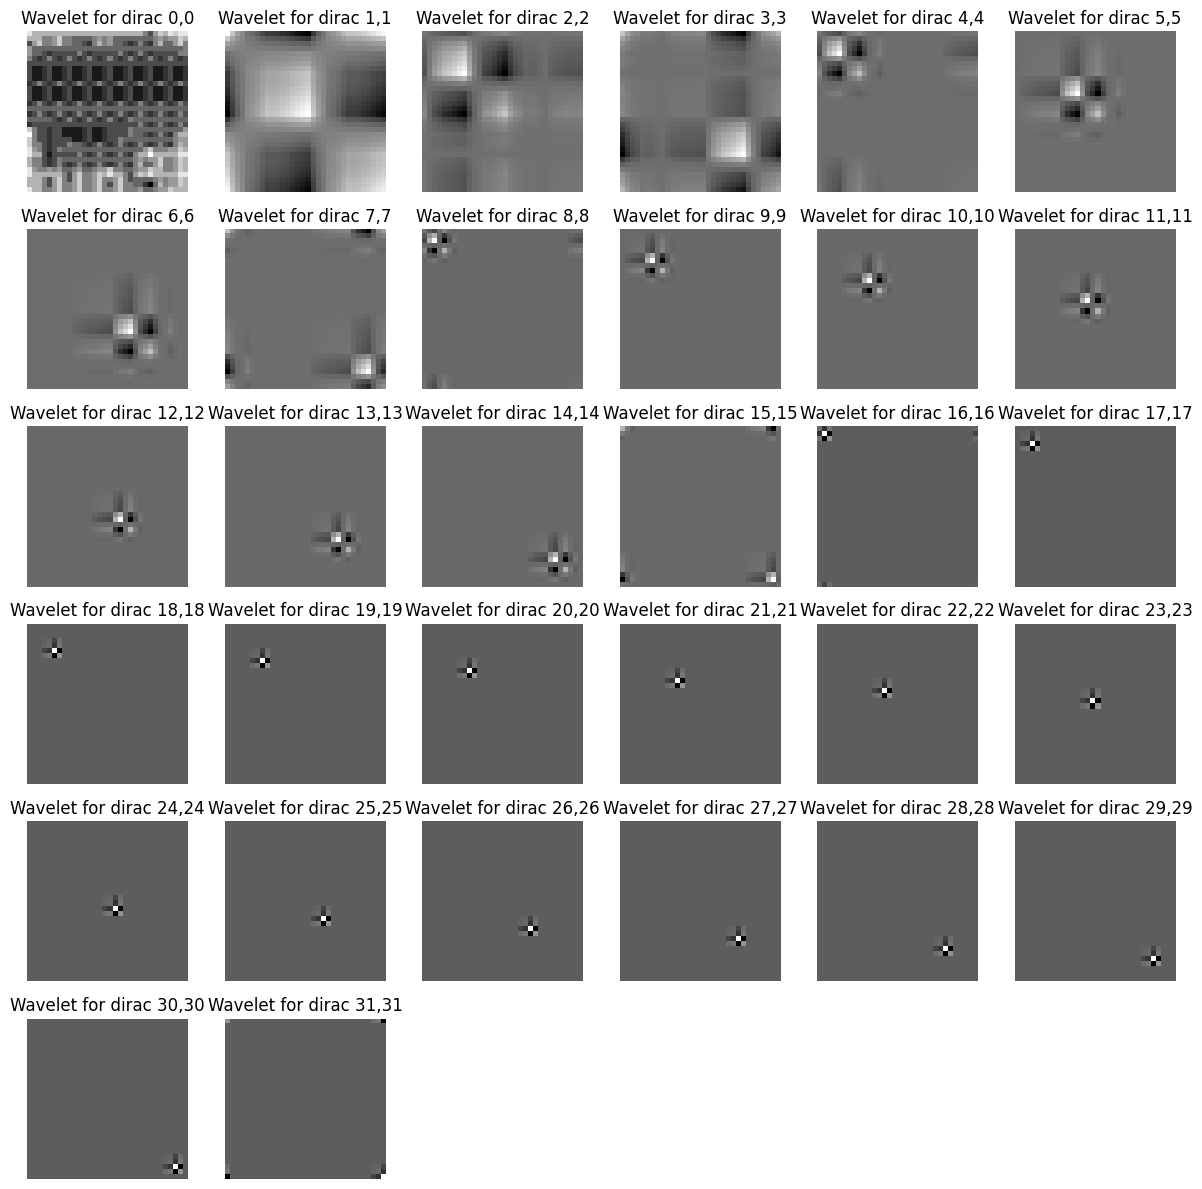

In [ ]:
# Define the Dirac delta function for each position on the diagonal
n = 32
dirac_images = []
for i in range(n):
    dirac = np.zeros((n, n))
    dirac[i, i] = 1
    dirac_images.append(dirac)

# Perform the inverse wavelet transform for each Dirac delta function
wavelets = []
for dirac in dirac_images:
    wavelet = perform_wavortho_transf(dirac, Jmin, -1, h)
    wavelets.append(wavelet)

# Display the 2-D wavelets
plt.figure(figsize=(12, 12))
for i, wavelet in enumerate(wavelets):
    plt.subplot(6, 6, i + 1)
    imageplot(wavelet, f'Wavelet for dirac {i},{i}')
plt.tight_layout()
plt.show()

# Cosine Transform

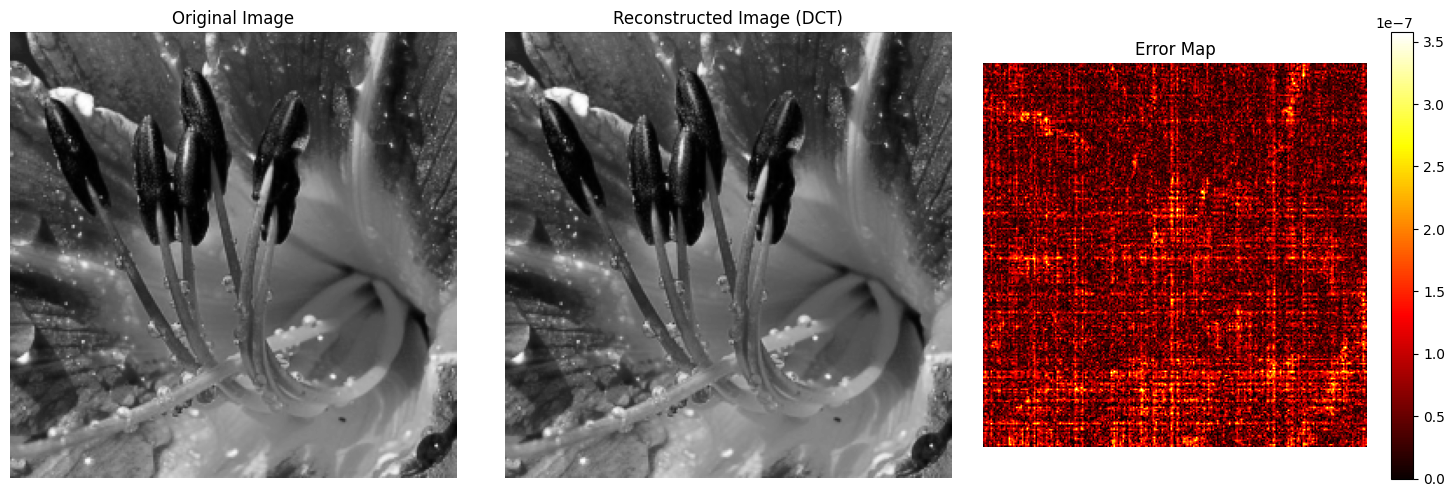

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct


n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)

def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

f_dct = dct2(f)
f_reconstructed = idct2(f_dct)


error = np.abs(f - f_reconstructed)


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(f, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(f_reconstructed, cmap='gray')
plt.title('Reconstructed Image (DCT)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(error, cmap='hot')
plt.title('Error Map')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()
